In [1]:
# Loading libraries

import pandas as pd
import matplotlib as mp


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn import decomposition as dcp
from sklearn.cluster import KMeans

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
# Loading the data
df=pd.read_csv('customer-personality.csv')

# Clean the data

## Checking and deleting duplicates

In [3]:
columns=df.columns
columns=columns.drop('ID')
df=df.drop_duplicates(subset=columns)
df.shape

(2039, 20)

## Exploring the marital status column to check if they have uniqie meanings

In [4]:
df['Marital_Status'].value_counts()

Married     788
Together    517
Single      445
Divorced    213
Widow        70
Alone         3
Absurd        2
YOLO          1
Name: Marital_Status, dtype: int64

Im terms of supermarket purchases 'married' or 'together' couples behave similarly, so we can group these two categories. 'Divorced', 'Widow', 'Alone' means that a person is likely to be 'Single', so we can group them as well. As for 'Absurd' and 'YOLO' we group it together with 'Other':

In [5]:

df["Marital_Status"]=df["Marital_Status"].map({
    "Absurd": "Other_status",
    "YOLO": "Other_status",
    "Together": "Together",
    "Married": "Together",
    "Single": "Single",
    "Divorced": "Single",
    "ALone": "Single",
    "Widow": "Single",

})

## Exploring the educational column to check if they have uniqie meanings

In [6]:
df['Education'].value_counts()

Graduation    1025
PhD            442
Master         337
2n Cycle       186
Basic           49
Name: Education, dtype: int64

In [7]:
df['Education']=df['Education'].replace(['2n Cycle'], 'Master')

## Changing the Date of enrollment from string to datetime format

In [8]:
df.Dt_Customer=pd.to_datetime(df['Dt_Customer'])

<ipython-input-8-29cf7fd12de0>:1: UserWarning: Parsing '21-08-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Dt_Customer=pd.to_datetime(df['Dt_Customer'])
<ipython-input-8-29cf7fd12de0>:1: UserWarning: Parsing '19-01-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Dt_Customer=pd.to_datetime(df['Dt_Customer'])
<ipython-input-8-29cf7fd12de0>:1: UserWarning: Parsing '13-11-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Dt_Customer=pd.to_datetime(df['Dt_Customer'])
<ipython-input-8-29cf7fd12de0>:1: UserWarning: Parsing '13-03-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Dt_Customer=pd.to_datetime(df['Dt_Customer'])
<ipython-input-8-29cf7fd12de0>:1: UserWarning: Parsing '15-11-2013' in DD/MM/YYYY format. Provide format or specify infer_dateti

## Checking and imputing NA values

In [9]:
 # There are 24 missing Income values. We will try to impute them using regression prediction
 df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          3
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
dtype: int64

In [10]:
# save a copy for original dataset
df_no_dummy=df.copy()

### Imputing the missing values using regression

In [11]:
#Create dummies for categorical data
df=pd.get_dummies(df)

In [12]:
df.isna().sum()

ID                              0
Year_Birth                      0
Income                         24
Kidhome                         0
Teenhome                        0
Dt_Customer                     0
Recency                         0
MntWines                        0
MntFruits                       0
MntMeatProducts                 0
MntFishProducts                 0
MntSweetProducts                0
MntGoldProds                    0
NumDealsPurchases               0
NumWebPurchases                 0
NumCatalogPurchases             0
NumStorePurchases               0
NumWebVisitsMonth               0
Education_Basic                 0
Education_Graduation            0
Education_Master                0
Education_PhD                   0
Marital_Status_Other_status     0
Marital_Status_Single           0
Marital_Status_Together         0
dtype: int64

In [13]:
#Now let's prepare for regression to predict salary based on other information
reg_columns=['Year_Birth', 'Kidhome',
       'Teenhome','Recency','NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Other_status', 'Marital_Status_Single',
       'Marital_Status_Together']
df_without_na=df.dropna()
X=df_without_na[reg_columns]
Y=df_without_na['Income']

After running the linear model 10 times, corresponding accuracies are  [0.7210384026206607, 0.7172669201096563, 0.5954612290517393, 0.21015793285835704, 0.6645375970770472, 0.7166551536225891, 0.16656781875213067, 0.6938952786863011, 0.6322089507782893, 0.7042901976324427]


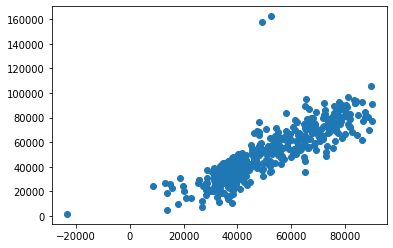

In [14]:
# Runing the regression for 10 random splits
lm = linear_model.LinearRegression()
accuracies=[]
for i in range(0,10):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
  model = lm.fit(X_train, y_train)
  predictions = lm.predict(X_test)
  score=model.score(X_test, y_test)
  accuracies.append(score)
print('After running the linear model 10 times, corresponding accuracies are ',accuracies)

#Most of accuracies are above 70%, which is considerably good for imputing missing na
#Observe how deviant are predicted vs true values of Income
plt.scatter(predictions,y_test)
plt.show()

In [15]:
#Using obtained model lm model we will predict missing values
df_na=df[df.isnull().any(axis=1)]
df[df.isnull().any(axis=1)].Income=lm.predict(df_na[X_test.columns])

#Now we add the predicted missing values to original dataset
df.loc[df.isnull().any(axis=1), 'Income'] = lm.predict(df_na[X_test.columns])

<ipython-input-15-fe3af64c6b99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.isnull().any(axis=1)].Income=lm.predict(df_na[X_test.columns])


# Feature Enginnering

## Creating Days_registrated column

In [16]:
# For future regression, we cannot use datetime object,so we derive difference between min and current day
# of registration:
df['Days_registrated'] = (df.Dt_Customer - df.Dt_Customer.min()).dt.days
df_no_dummy['Days_registrated'] = (df_no_dummy.Dt_Customer - df_no_dummy.Dt_Customer.min()).dt.days

## Creating a feature: age of customer entered the company

In [17]:
df['Entered_age']=df['Dt_Customer'].dt.year-df['Year_Birth']
df_no_dummy['Entered_age']=df_no_dummy['Dt_Customer'].dt.year-df_no_dummy['Year_Birth']

## Creating a feature: total spending per customer

In [18]:
df['Total_spent']= df.loc[:,('MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds','MntWines') ].sum(axis=1)
df_no_dummy['Total_spent']= df_no_dummy.loc[:,('MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds','MntWines') ].sum(axis=1)

In [19]:
min(df['Total_spent'])

4

It means that each person spent at least 1.

## Creating a feature: total visits per customer

In [20]:
df['Total_visits'] = (df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases'])
df_no_dummy['Total_visits'] = (df_no_dummy['NumWebPurchases']+df_no_dummy['NumCatalogPurchases']+df_no_dummy['NumStorePurchases'])

In [21]:
min(df['Total_visits'])

0

In [22]:
df[df['Total_visits']==0].shape[0]

6

It turned out that some customers bought something, but they did not have any visits. In order to calculate the averate purchase we need to replace it to ones:

In [23]:
df['Total_visits']=  df['Total_visits'].replace(0, 1)
df_no_dummy['Total_visits']=  df_no_dummy['Total_visits'].replace(0, 1)

## Creating a feature: average amount per purchase per customer

In [24]:
df['Average_purchase']=df['Total_spent']/df['Total_visits']
df_no_dummy['Average_purchase']=df_no_dummy['Total_spent']/df_no_dummy['Total_visits']

# Exploring the Overall Dataset

In [25]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Education_Master,Education_PhD,Marital_Status_Other_status,Marital_Status_Single,Marital_Status_Together,Days_registrated,Entered_age,Total_spent,Total_visits,Average_purchase
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,...,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,5591.690535,1968.768024,52337.743966,0.444826,0.507602,49.096616,303.332026,26.351153,167.755272,37.456596,...,0.256498,0.216773,0.001471,0.357038,0.640020,552.795978,44.265817,579.519863,12.532614,36.601710
std,3257.763252,11.983086,25491.948415,0.537843,0.546930,28.974507,335.823263,39.824028,227.930430,54.704882,...,0.436807,0.412148,0.038339,0.479244,0.480112,231.958286,12.023895,578.506931,7.183477,46.566334
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,4.000000,1.000000,2.666667
25%,2804.500000,1959.000000,35533.500000,0.000000,0.000000,24.000000,23.000000,2.000000,16.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,380.000000,36.000000,63.000000,6.000000,12.166667
50%,5510.000000,1970.000000,51479.000000,0.000000,0.000000,49.000000,174.000000,8.000000,67.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,552.000000,43.000000,376.000000,12.000000,28.375000
75%,8434.500000,1977.000000,68557.000000,1.000000,1.000000,74.000000,503.500000,33.000000,230.000000,50.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,724.500000,54.000000,982.000000,18.000000,48.370130
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1063.000000,121.000000,2464.000000,32.000000,1677.000000


Let's see the initial distributions for our data:

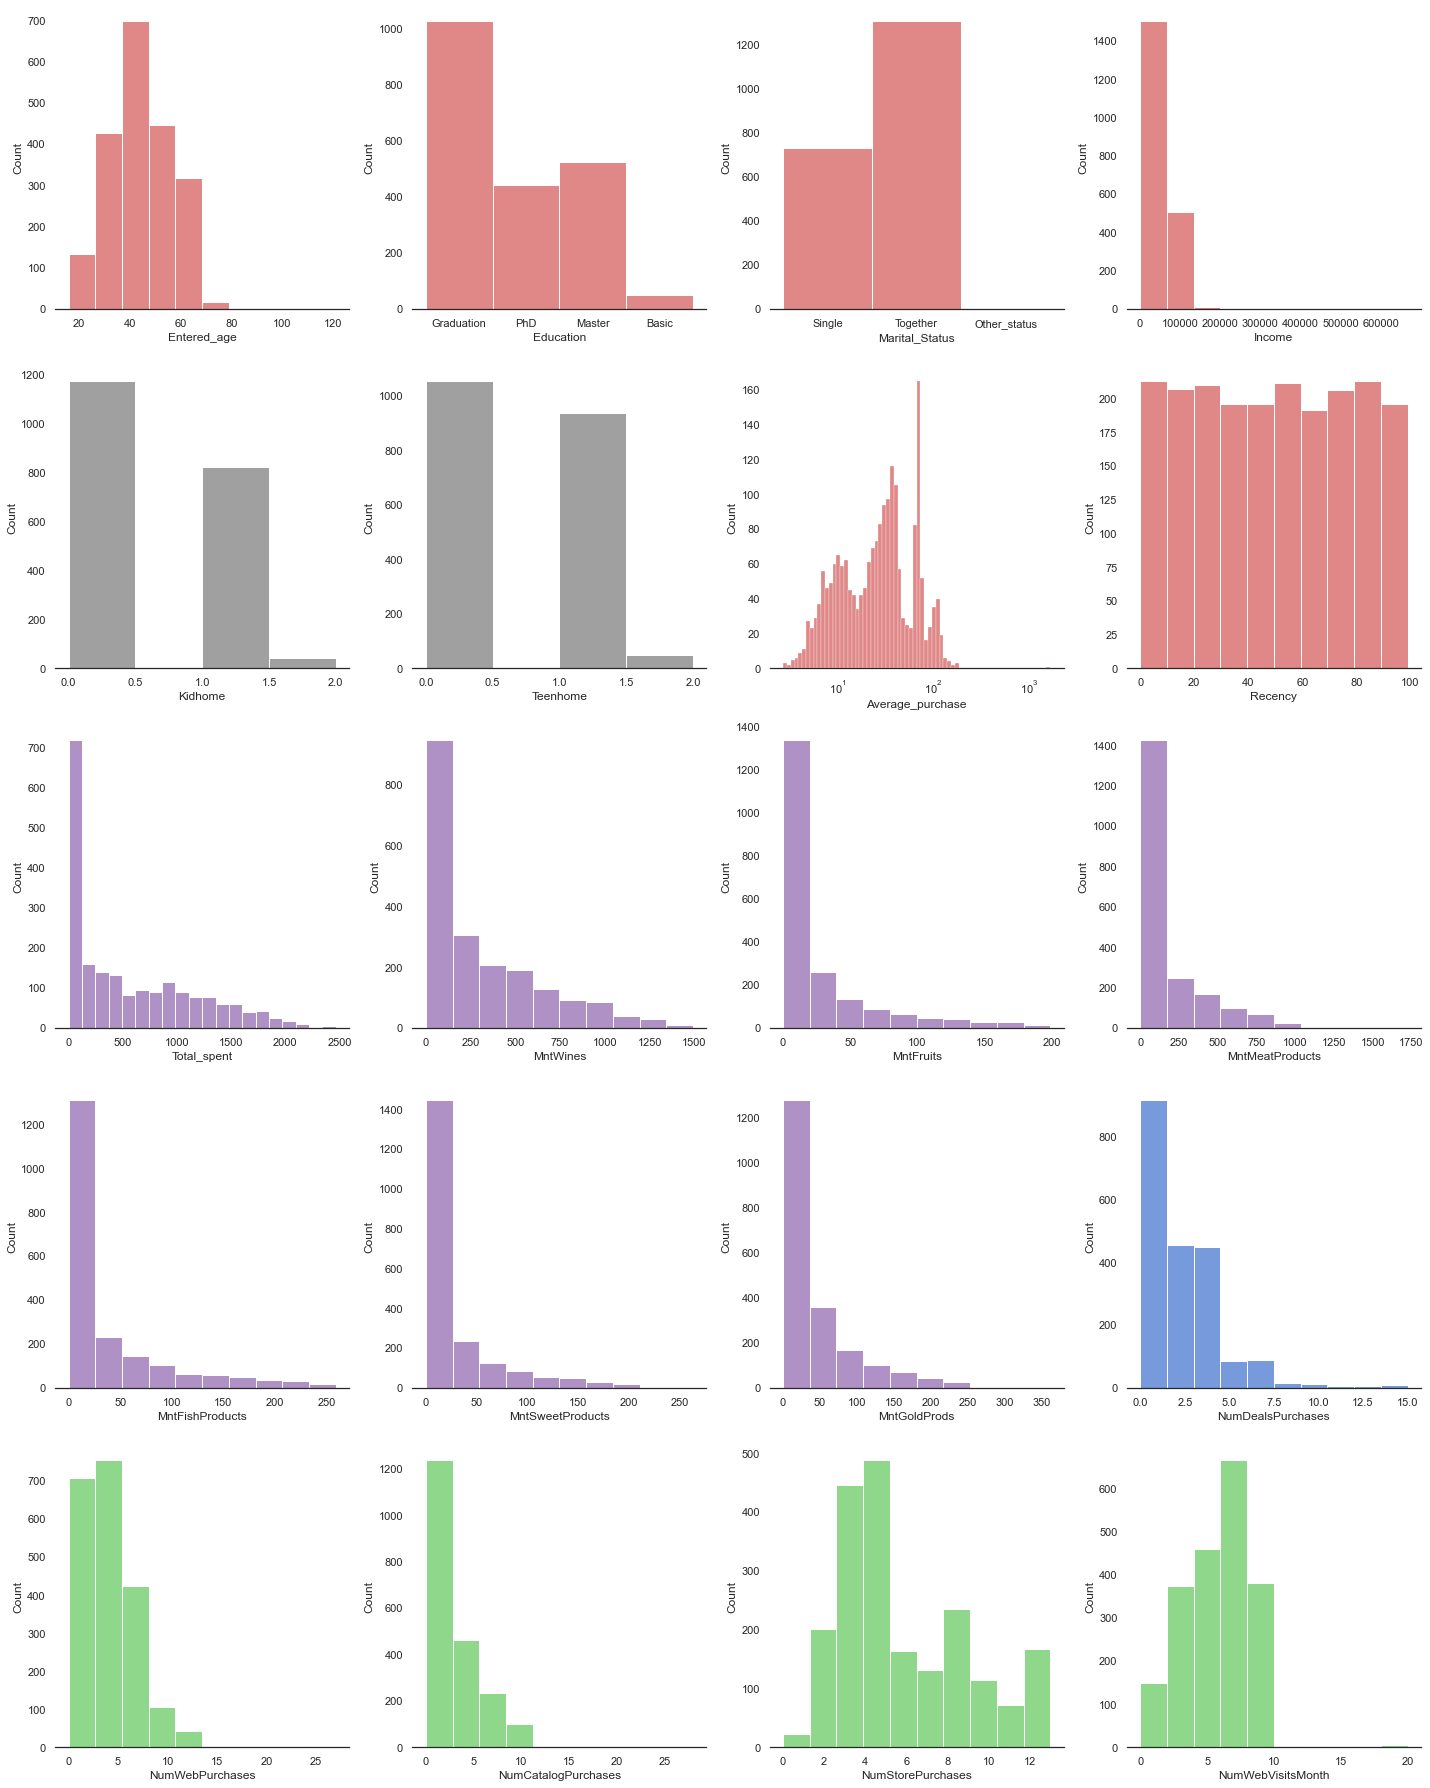

In [26]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(5, 4, figsize=(20, 25), sharex=False)
sns.despine(left=True)

#create subplots
d= df_no_dummy['Entered_age']
sns.histplot(d, kde=False, color="r", ax=axes[0, 0], bins = 10)

up = df_no_dummy['Education']
sns.histplot(up,  kde=False, color="r", ax=axes[0, 1], bins = 10)

ms = df_no_dummy['Marital_Status']
sns.histplot(ms,  kde=False, color="r", ax=axes[0, 2], bins = 10)

income = df_no_dummy['Income']
sns.histplot(income,  kde=False, color="r", ax=axes[0, 3], bins = 10)



kid = df_no_dummy['Kidhome']
sns.histplot(kid,  kde=False, color="grey", ax=axes[1, 0], bins = 4)

teen = df_no_dummy['Teenhome']
sns.histplot(teen,  kde=False, color="grey", ax=axes[1, 1], bins = 4)


age = df_no_dummy['Average_purchase']
sns.histplot(age,  kde=False, color="r", ax=axes[1, 2], bins = 70,  log_scale=True)

rec = df_no_dummy['Recency']
sns.histplot(rec,  kde=False, color="r", ax=axes[1, 3], bins = 10)


ts = df_no_dummy['Total_spent']
sns.histplot(ts,  kde=False, color="m", ax=axes[2, 0], bins = 20)


m_w = df_no_dummy['MntWines']
sns.histplot(m_w, color="m", kde=False, ax=axes[2, 1], bins = 10)


m_f = df_no_dummy['MntFruits']
sns.histplot(m_f, color="m",kde=False, ax=axes[2, 2], bins = 10)

m_m = df_no_dummy['MntMeatProducts']
sns.histplot(m_m, color="m", kde=False, ax=axes[2, 3], bins = 10)


m_fish = df_no_dummy['MntFishProducts']
sns.histplot(m_fish, color="m",kde=False, ax=axes[3, 0], bins = 10)

m_sw = df_no_dummy['MntSweetProducts']
sns.histplot(m_sw, color="m", kde=False, ax=axes[3, 1], bins = 10)


m_g = df_no_dummy['MntGoldProds']
sns.histplot(m_g, color="m",kde=False, ax=axes[3, 2], bins = 10)


ndp = df_no_dummy['NumDealsPurchases']
sns.histplot(ndp, color="b", kde=False, ax=axes[3, 3], bins = 10)


nwp = df_no_dummy['NumWebPurchases']
sns.histplot(nwp, color="g",kde=False, ax=axes[4, 0], bins = 10)

ncp = df_no_dummy['NumCatalogPurchases']
sns.histplot(ncp, color="g", kde=False, ax=axes[4, 1], bins = 10)


nsp = df_no_dummy['NumStorePurchases']
sns.histplot(nsp, color="g",kde=False, ax=axes[4, 2], bins = 10)

nwvm = df_no_dummy['NumWebVisitsMonth']
sns.histplot(nwvm, color="g", kde=False, ax=axes[4, 3], bins = 10)


plt.tight_layout()

We see that there is an "Income" outlier, and large values for 'Age'. Let's delete those outliers:

In [27]:
max(df['Income'])

666666.0

We noticed that we have outliers in income and year of birth with values 66666 and year less than 1942. So we will delete these observations.

In [28]:
# Deleting an Income outlier where Income is 666666 because it is outlier (and most likely incorrect data)

df = df[df.Income != 666666]
df_no_dummy = df_no_dummy[df_no_dummy.Income != 666666]

In [29]:
# Deleting those who were born before 1942 as they are likely to be errors

df=df[df['Year_Birth']>1942]
df_no_dummy = df_no_dummy[df_no_dummy['Year_Birth']>1942]

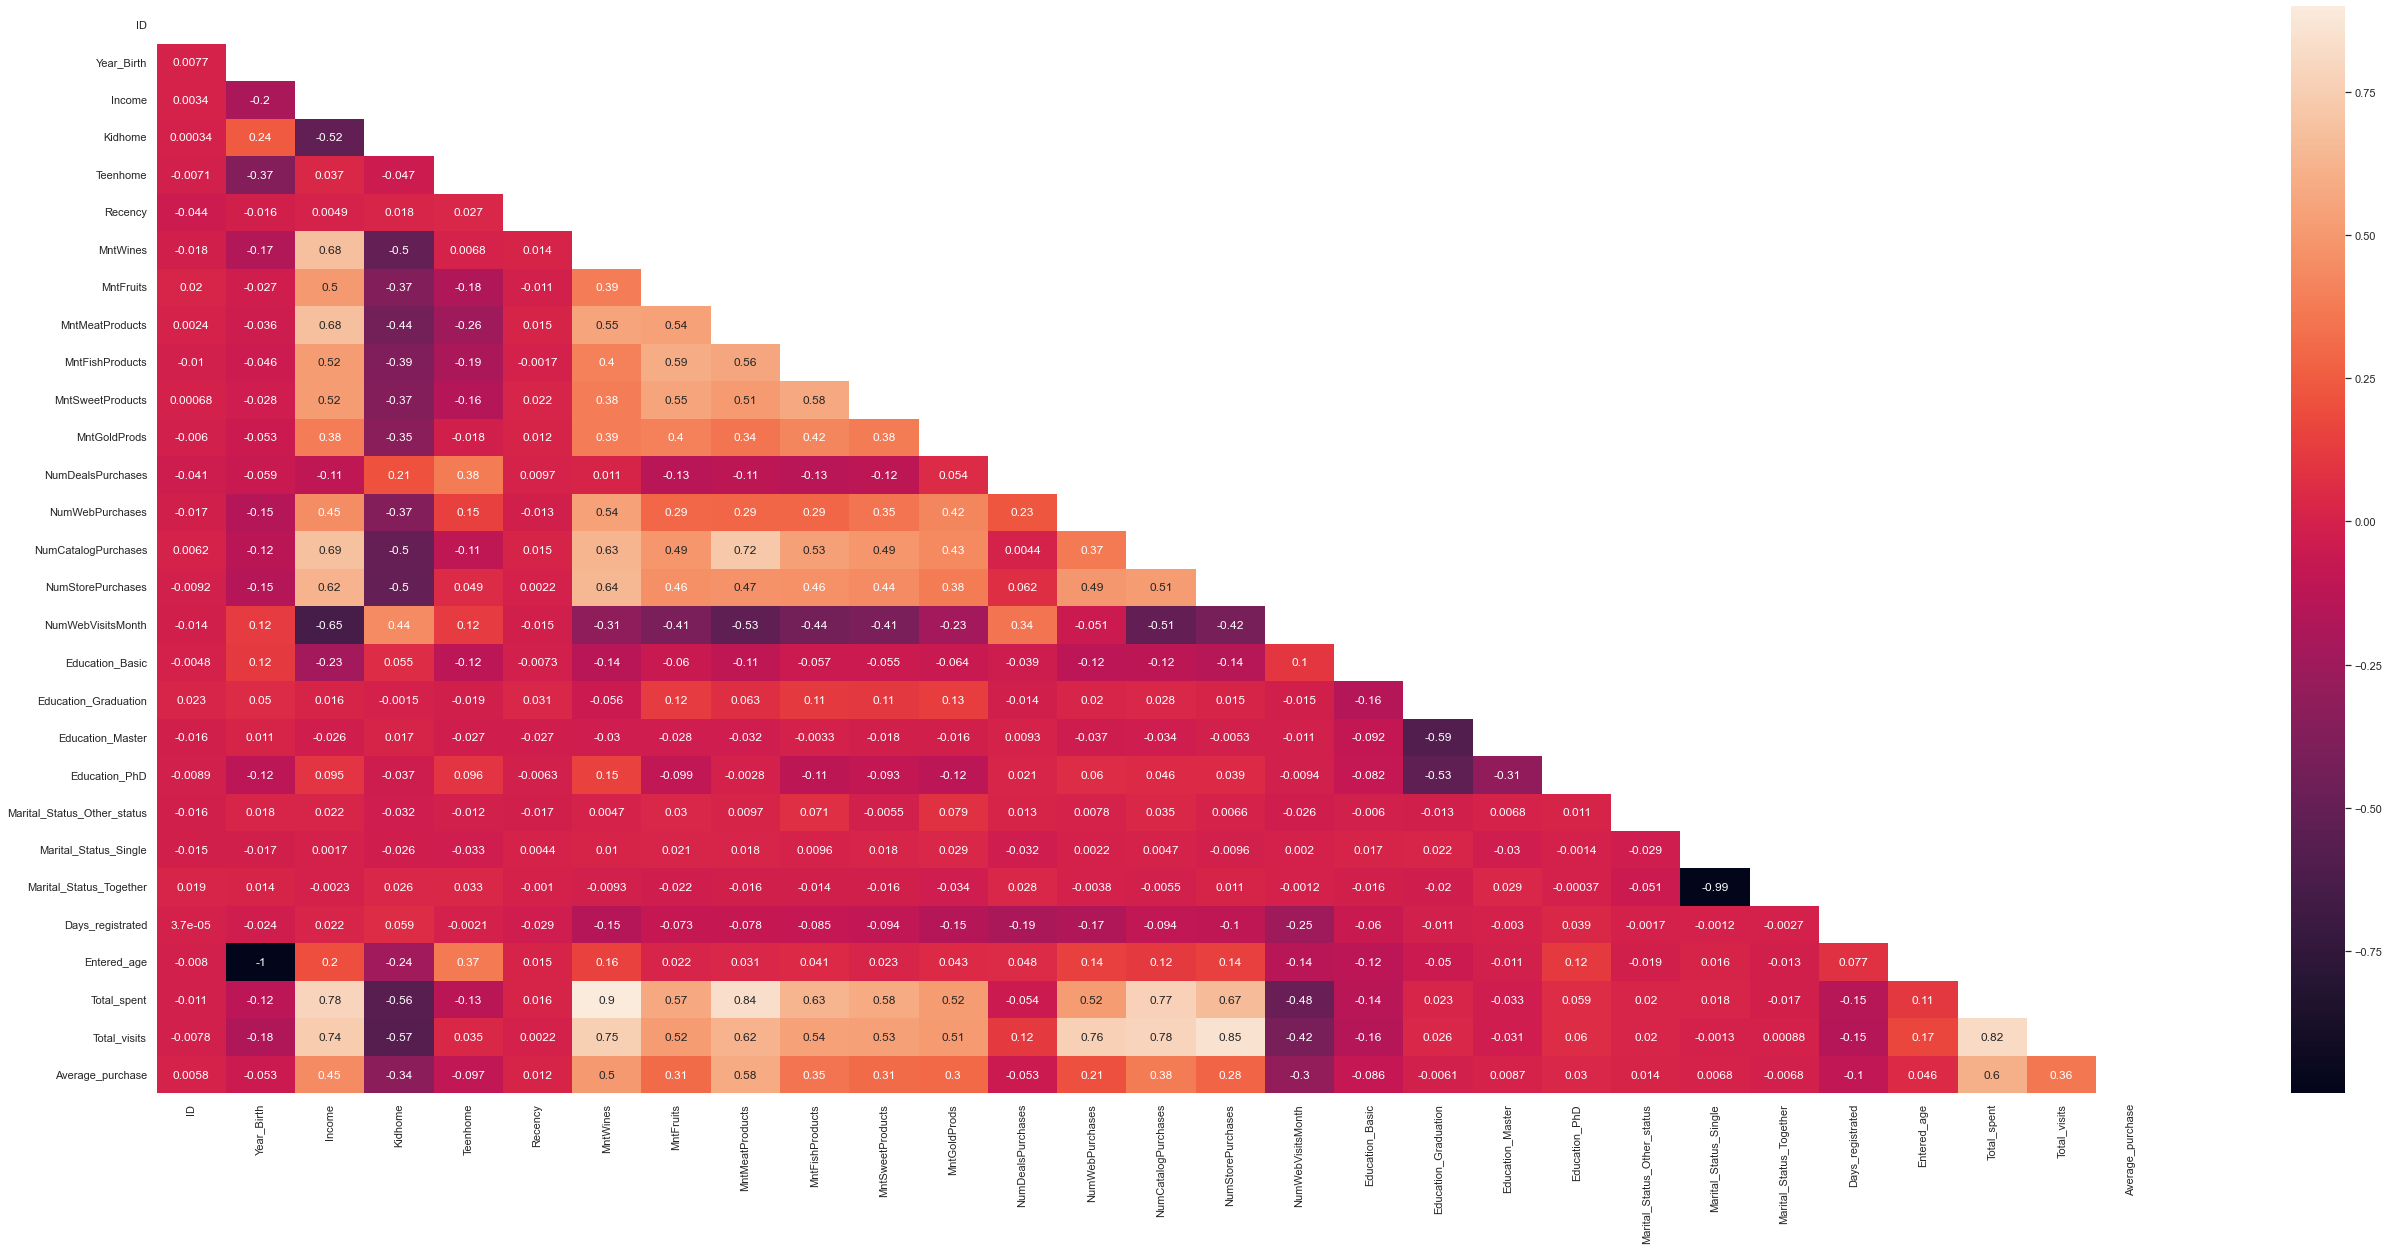

In [30]:
# Creating a correlation matrix to check for correlation between the variables

plt.figure(figsize=(45,20))

correlation_matrix = df.corr()

mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix, annot=True, mask=mask)
plt.show()

## Plotting the relation between total spending and income per customer in regard to education level

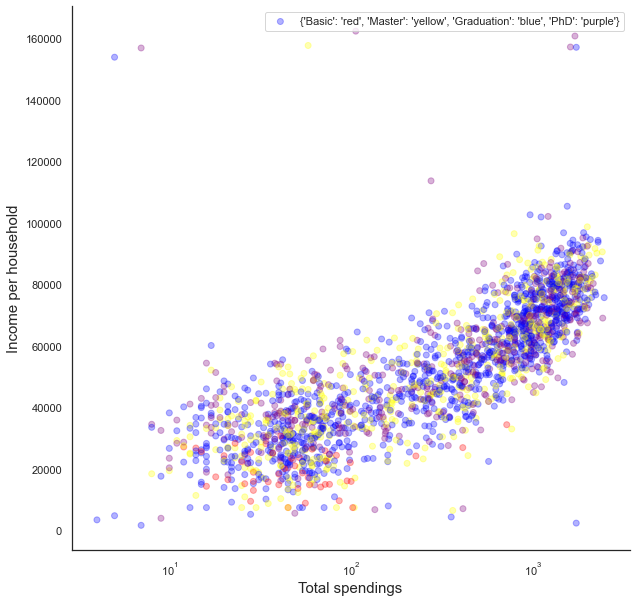

In [31]:
# Plotting the relationship between total spending and income per customer 
# in regard to Marital Status

colors2 = {'Basic':'red', 'Master':'yellow', 
           'Graduation':'blue', "PhD": 'purple' }

#Plot the relationship between salary and spending
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


ax.scatter(df_no_dummy['Total_spent'],df_no_dummy['Income'], alpha = 0.3,
           c = df_no_dummy['Education'].map(colors2), label=colors2)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Total spendings', size = 15)
ax.set_ylabel('Income per household', size = 15)
ax.legend()


plt.show()

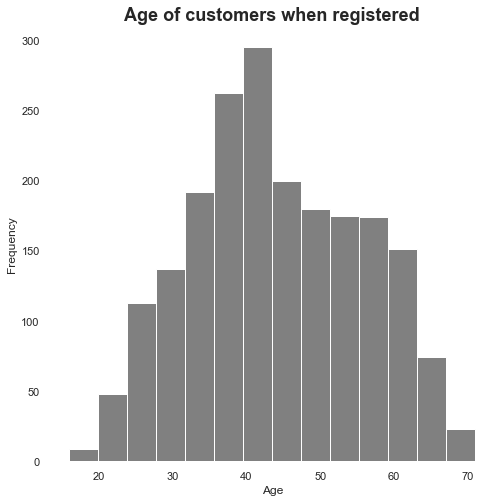

In [32]:
# Let's discover the age of the customers when registered

figs = plt.figure(figsize=(8, 8))

# initializing the plot
ax = figs.add_subplot(1, 1, 1)

# labels

ax.set_title('Age of customers when registered', fontdict={'fontsize': 18, 'fontweight': 'bold'})
ax.set_ylabel('Frequency')
ax.set_xlabel('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plot the data
plt.hist(df['Entered_age'],color='grey',bins=14)

# show plot
plt.show()

In [33]:
#Age mean and median
print('Age mean is '+str(df['Entered_age'].mean()))
print('Age median is '+str(df['Entered_age'].median()))

Age mean is 44.13625184456468
Age median is 43.0


What is the age range of customers who sign up for the store? The histograms assist the company in categorising customers based on age and adjusting marketing activities based on this differentiation. The distribution is right skewed, with a mean of 44.

## Plotting the customer spendings regarding the distribution channels of the company

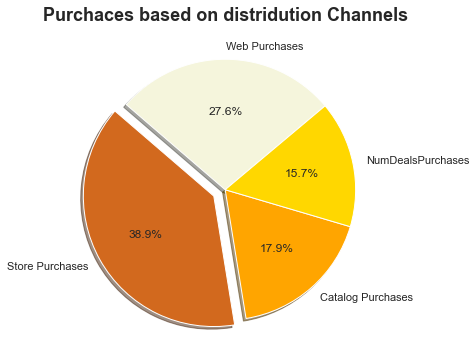

In [34]:
# We can see that out of the three channels the one with the most purchases are the physical store

figs = plt.figure(figsize=(6, 6))

# initializing the plot
ax = figs.add_subplot(1, 1, 1)

# labels
labels = ('Web Purchases', 'Store Purchases', 'Catalog Purchases','NumDealsPurchases')

ax.set_title('Purchaces based on distridution Channels', fontdict={'fontsize': 18, 'fontweight': 'bold'})

# properties of the pie charts
sizes = [sum(df['NumWebPurchases']), sum(df['NumStorePurchases']), sum(df['NumCatalogPurchases']),
        sum(df['NumDealsPurchases'])]
explode = (0, 0.1, 0, 0)

#plot the data
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True,colors=('beige', 'chocolate', 'orange','gold'), startangle=40)

# show plot
plt.show()

## Plotting the customer spendings per offered product

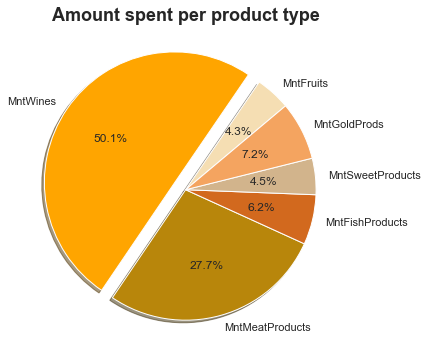

In [35]:
figs1 = plt.figure(figsize=(6, 6))

# initializing the plot
ax = figs1.add_subplot(1, 1, 1)

# labels
labels = ('MntFruits', 'MntWines', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds')

ax.set_title('Amount spent per product type', fontdict={'fontsize': 18, 'fontweight': 'bold'})

# properties of the pie charts
sizes = [sum(df['MntFruits']), sum(df['MntWines']), sum(df['MntMeatProducts']),
         sum(df['MntFishProducts']),sum(df['MntSweetProducts']),sum(df['MntGoldProds']),]
explode = (0, 0.1, 0, 0, 0, 0)

#plot the data
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, colors = ('wheat', 'orange','darkgoldenrod','chocolate','tan', 'sandybrown'), startangle=40)

# show plot
plt.show()

## Plotting the relation of the month that the customer signed app with it's total spendings

In [36]:
df_month_signed = df.copy()
df_month_signed['Dt_Month'] = df_month_signed.Dt_Customer.dt.month
df_month_signed['Dt_Year'] = df_month_signed.Dt_Customer.dt.year

In [37]:
# See month that they sign with their spending on specific product
df_months = pd.DataFrame(df_month_signed.groupby('Dt_Month', as_index=False)[['Income','Year_Birth','Entered_age','MntWines',
                                                 'MntFruits', 'MntMeatProducts',
                                                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                                                 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                                                 'NumStorePurchases', 'NumWebVisitsMonth', 'Total_spent']].mean())
df_months

,Dt_Month,Income,Year_Birth,Entered_age,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_spent
0,1,52452.092238,1968.357955,44.994318,310.840909,31.562500,161.852273,40.494318,26.250000,42.267045,2.494318,4.164773,2.784091,6.142045,5.278409,581.704545
1,2,52654.750348,1970.201220,43.085366,309.957317,31.725610,172.878049,47.768293,35.286585,50.335366,2.207317,4.262195,2.786585,6.195122,5.097561,616.225610
2,3,51090.808716,1967.719577,45.571429,283.476190,22.047619,139.947090,31.814815,22.275132,38.137566,2.476190,3.931217,2.280423,5.486772,5.306878,515.650794
3,4,51888.048780,1970.115854,43.201220,237.615854,19.823171,166.237805,34.378049,24.402439,40.006098,2.000000,3.524390,2.762195,5.256098,5.006098,502.640244
4,5,53605.218195,1968.431818,44.892045,301.357955,26.142045,173.380682,34.244318,29.465909,40.051136,2.267045,4.340909,2.607955,5.982955,4.977273,578.500000
5,6,50967.901635,1967.725490,45.568627,256.065359,23.457516,159.143791,33.209150,26.679739,38.738562,2.307190,3.771242,2.686275,5.267974,5.143791,513.836601
6,7,50571.876923,1968.046154,44.946154,291.353846,23.030769,134.946154,30.692308,22.300000,44.492308,2.346154,4.392308,2.523077,5.453846,5.684615,523.784615
7,8,50202.298582,1969.209424,43.439791,321.518325,26.277487,165.167539,37.738220,26.068063,44.874346,2.565445,4.120419,2.507853,5.916230,5.895288,595.366492
8,9,54926.260041,1968.666667,44.019608,365.228758,28.751634,195.980392,49.196078,36.111111,53.934641,2.359477,4.026144,2.888889,6.294118,5.287582,700.450980
9,10,50486.446200,1970.289474,42.436842,297.815789,26.426316,159.615789,35.447368,23.000000,45.210526,2.378947,4.152632,2.521053,5.442105,5.594737,561.089474


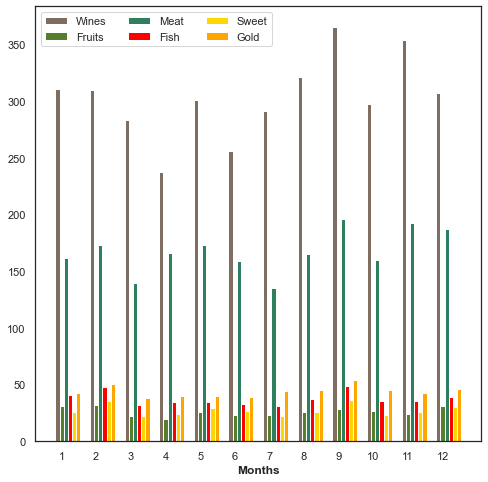

In [38]:
# Plotting the spendings per month in all the offered products 

plt.figure(figsize = (8,8))

# set width of bars
barWidth = 0.12

# Set position of bar on X axis
r1 = np.arange(12)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

 
# Make the plot
plt.bar(r1, df_months['MntWines'], color='#7f6d5f', width=barWidth, edgecolor='white', label='Wines')
plt.bar(r2, df_months['MntFruits'], color='#557f2d', width=barWidth, edgecolor='white', label='Fruits')
plt.bar(r3, df_months['MntMeatProducts'], color='#2d7f5e', width=barWidth, edgecolor='white', label='Meat')
plt.bar(r4, df_months['MntFishProducts'], color='red', width=barWidth, edgecolor='white', label='Fish')
plt.bar(r5, df_months['MntSweetProducts'], color='gold', width=barWidth, edgecolor='white', label='Sweet')
plt.bar(r6, df_months['MntGoldProds'], color='orange', width=barWidth, edgecolor='white', label='Gold')

    
# Add xticks on the middle of the group bars
plt.xlabel('Months', fontweight='bold')
plt.xticks([r + barWidth for r in range(12)], ['1', '2', '3', '4', '5','6', '7', '8', '9', '10','11','12'])


# Create legend & Show graphic
plt.legend(loc = 'best', ncol = 3 )
plt.show()

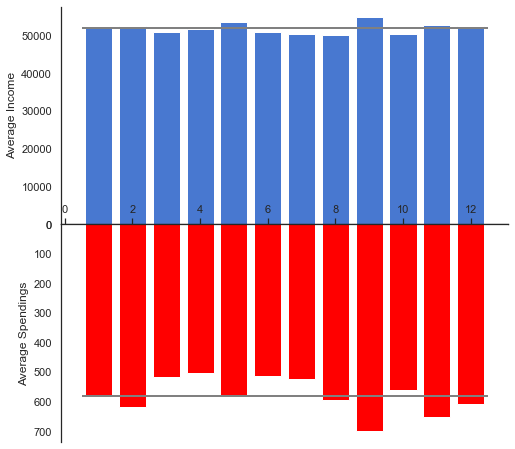

In [39]:
fig = plt.figure(figsize=(8,8))

ax1= fig.add_subplot(2,1,1)
ax2= fig.add_subplot(2,1,2)


ax1.bar(df_months['Dt_Month'], df_months['Income'] )
ax2.bar(df_months['Dt_Month'], df_months['Total_spent'], color='red')

ax1.set_ylabel('Average Income')
ax2.set_ylabel('Average Spendings')

ax1.hlines(y=np.mean(df_months['Income']), xmin=0.5, xmax=12.5  , linewidth=2, color='grey')
ax2.hlines(y=np.mean(df_months['Total_spent']), xmin=0.5, xmax=12.5 , linewidth=2, color='grey')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.xaxis.tick_top()
ax2.invert_yaxis()

plt.subplots_adjust(wspace=0, hspace=0.0010)

## Plotting the total spendings per each category for different Age Groups

In [40]:
# Preparing the dataset for the visualisation
df_age_groups = df.copy()

#Creating new features: AgeGrops
df_age_groups.loc[(df_age_groups['Entered_age'] <30) , 'AgeGroup'] = '<30'
df_age_groups.loc[(df_age_groups['Entered_age'] >=30)&(df['Entered_age']<40) , 'AgeGroup'] = '30-40'
df_age_groups.loc[(df_age_groups['Entered_age'] >=40)&(df['Entered_age']<50) , 'AgeGroup'] = '40-50'
df_age_groups.loc[(df_age_groups['Entered_age'] >=50)&(df['Entered_age']<60) , 'AgeGroup'] = '50-60'
df_age_groups.loc[df_age_groups['Entered_age'] >=60 , 'AgeGroup'] = '>60'

In [41]:
#how many people per groups?
df_age_groups.groupby(['AgeGroup']).size()

AgeGroup
30-40    537
40-50    597
50-60    427
<30      224
>60      248
dtype: int64

In [42]:
#Creating new features: total spent on each category
columns_categories=['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_dict={}
k=1
for i in columns_categories:
    df_dict[k]=df_age_groups.groupby(['AgeGroup']).agg({i:'sum'}).reset_index()
    k+=1
merged=df_dict[1].loc[:,'AgeGroup']
k=2
for i in df_dict:
    merged=pd.merge(merged, df_dict[i], on="AgeGroup")

In [43]:
#Sort rows manually 
custom_dict = {'<30': 0, '30-40': 1, '40-50': 2,'50-60': 3, '>60': 4} 

merged.sort_values(by=['AgeGroup'], key=lambda x: x.map(custom_dict),inplace=True)

In [44]:
#Insert corresponding group sizes
merged['Group_size']=[224,537,597,427,248]    

In [45]:
#Consumption per person in each Age group
for i in ['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']:
    merged[i]=merged[i]/merged.Group_size

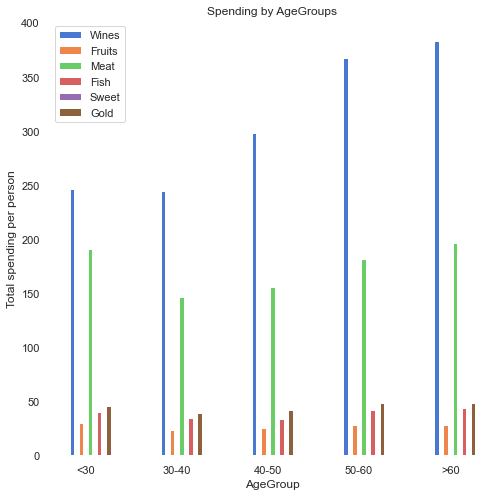

In [46]:
#Plotting the amount spent on each catogory by different ages

figs = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
categories=merged.AgeGroup
x_axis = np.arange(5)

# Multi bar Chart
plt.bar(x_axis +0.10, merged.iloc[:,1], width=0.05, label = 'Wines')
plt.bar(x_axis +0.10*2,  merged.iloc[:,2], width=0.05, label = 'Fruits')
plt.bar(x_axis +0.10*3,  merged.iloc[:,3], width=0.05, label = 'Meat')
plt.bar(x_axis +0.10*4,  merged.iloc[:,4], width=0.05, label = 'Fish')
plt.bar(x_axis +0.10*5,  merged.iloc[:,5], width=0.05, label = 'Sweet')
plt.bar(x_axis +0.10*5,  merged.iloc[:,6], width=0.05, label = 'Gold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend()
plt.title('Spending by AgeGroups')
ax.set_ylabel('Total spending per person')
ax.set_xlabel('AgeGroup')
plt.xticks(x_axis+0.25,categories)
plt.show()

How do different age groups differ in their spending habits? Are there any patterns? The graph shows that Wines contribute the most to each group's spending. However, for the youngest generation, the difference between Wines and the second most common expenditure – meat – is negligible. On average, the greater the age of the customer (over 30 years old), the greater the spending. Customer spending proportions are very similar across all groups.

## Plotting the percetage of total spent per each category by different Education groups

In [47]:
# Preparing the dataset for the visualisation
df_educ = df_no_dummy.copy()

#create a list of names of new features (percentage_spent)
education_columns_percent=[]
for i in columns_categories:
    df_educ[str(i)+'_percent']=df_educ[i]/df_educ['Total_spent']
    education_columns_percent.append(str(i)+'_percent')

In [48]:
#Plot the % spent on each category by different educational level

k=1
df_dict={}
for i in education_columns_percent:
    df_dict[k]=df_educ.groupby(['Education']).agg({i:'mean'}).reset_index()
    k+=1
merged=df_dict[1].loc[:,'Education']
k=2
for i in df_dict:
    merged=pd.merge(merged, df_dict[i], on="Education")

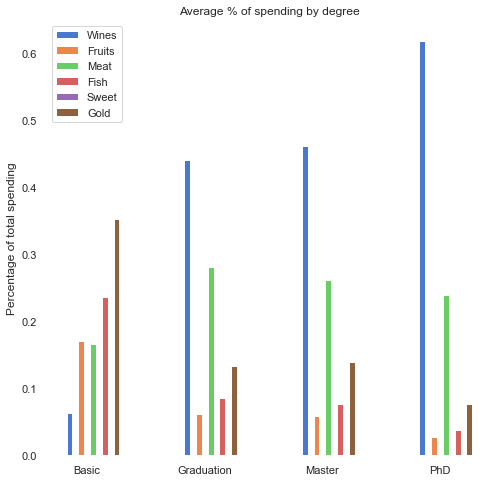

In [49]:
figs = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
categories=merged.Education
x_axis = np.arange(4)
plt.bar(x_axis +0.10, merged.iloc[:,1], width=0.05, label = 'Wines')
plt.bar(x_axis +0.10*2,  merged.iloc[:,2], width=0.05, label = 'Fruits')
plt.bar(x_axis +0.10*3,  merged.iloc[:,3], width=0.05, label = 'Meat')
plt.bar(x_axis +0.10*4,  merged.iloc[:,4], width=0.05, label = 'Fish')
plt.bar(x_axis +0.10*5,  merged.iloc[:,5], width=0.05, label = 'Sweet')
plt.bar(x_axis +0.10*5,  merged.iloc[:,6], width=0.05, label = 'Gold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Average % of spending by degree')
ax.set_ylabel('Percentage of total spending')
plt.legend()
plt.xticks(x_axis+0.25,categories)
plt.show()

Understanding customer behaviour is a critical component of any business. According to the preliminary descriptive analysis, education level, among other factors, significantly differentiates clients in terms of spending preferences and income. The bar graph shows how much each product contributes to each educational group. Thus, for a basic degree, the wine corresponds to less than 8%, whereas for a PhD, it exceeds 60%. Graduation, Master's, and PhD students spend the most money on wine. As a result, the company should focus its marketing efforts on the Wines category for these groups. Another takeaway from the chart is that, with the exception of Wine, the majority of category shares decrease as one progresses from Basic to PhD. The higher your degree, the more likely you are to be able to afford wine and the less reliant you are on meat, fish, fruits, and gold prices. The transition from Graduation to Master, on the other hand, has no tangible impact on purchasing behaviour.

## Plotting the relation between income and marital status

In [50]:
# Preparing the dataset for the visualisation
df_income_marital=df_no_dummy[["Income", "Marital_Status"]]
df_income_marital.dropna(inplace=True)

<ipython-input-50-93535272748f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income_marital.dropna(inplace=True)


In [51]:
fig = px.histogram(df_income_marital, 
                   x='Income', 
                   color='Marital_Status', 
                   color_discrete_sequence=['blue', 'green','red','yellow','orange','purple'], 
                   title='Income level by marital status')
fig.update_layout(bargap=0.1)
fig.show()

We can see from the figure that no obvious relations between income and marital status. One fact is that more than a half of the people are "together", regardless of the income level.

## Plotting relation between income and number of children (higher income 0 kids)

In [52]:
# Preparing the dataset for the visualisation
df_kinds = df_no_dummy.copy() 

# Creating new feature: Minorhome
df_kinds["Minorhome"]=df_kinds.Kidhome+df_kinds.Teenhome
df_kinds.drop(columns=["Kidhome","Teenhome"], inplace=True)

df_income_children=df_kinds[["Income", "Minorhome"]]

In [53]:
fig = px.histogram(df_income_children, 
                   x='Income', 
                   color='Minorhome', 
                   color_discrete_sequence=['blue', 'green','red','yellow'], 
                   title='Income level by number of children')
fig.update_layout(bargap=0.1)
fig.show()

We can see that with the increase of the income level, more people have fewer kids, especially between 60k and 100k, the number of people with no kids increases and reaches peak at around 80k. For people with three kids, their income level are mainly within the range 30k to 65k. Similarly for people with two kids, their income range is mainly between 20k to 65k. One kid is still the most cases for people with income below 70k.

## Plotting the relation between education level and marital status

In [54]:
# Preparing the dataset for the visualisation
df_educ_marital=df_no_dummy[["Education","Marital_Status"]]
df_educ_marital.dropna(inplace=True)

<ipython-input-54-df5d1bbb231d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
fig = px.histogram(df_educ_marital, 
                   x='Education', 
                   category_orders=dict(Education=["Basic", "Graduation", "Master", "PhD"]),
                   color='Marital_Status', 
                   color_discrete_sequence=['blue', 'green','red'],
                   title='Relation between education level and marital status')
fig.update_layout(bargap=0.8)
fig.show()

We cannot see much differences in different education level vs marital status.

## Ploting the relation between education level and number of children

In [56]:
# Preparing the dataset for the visualisation

df_educ_child = df_kinds[["Education","Minorhome"]]

In [57]:
fig = px.histogram(df_educ_child, 
                   x='Education', 
                   category_orders=dict(Education=["Basic", "Graduation", "Master", "PhD"]),
                   color='Minorhome', 
                   color_discrete_sequence=['blue', 'green','red','yellow'], 
                   title='Relation between education level and number of children')
fig.update_layout(bargap=0.8)
fig.show()

We cannot see much differences in different education level vs number of kids. One kid is always the majority choice. 

# Unsupervised Learning methods for further investigation

## Performing Factor Analysis

In [58]:
# Preparing the data for Factor Analysis
data_FA = df.copy()
# Deleding na values
data_FA.dropna(inplace = True)
# Droping some unecessary columns
data_FA.drop(['Dt_Customer','ID'], axis=1, inplace= True)
data_FA.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Master,Education_PhD,Marital_Status_Other_status,Marital_Status_Single,Marital_Status_Together,Days_registrated,Entered_age,Total_spent,Total_visits,Average_purchase
0,1957,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,0,92,55,1529,22,69.500000
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,1,0,938,60,26,4,6.500000
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,1,591,48,727,20,36.350000
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,1,998,30,49,6,8.166667
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0,1,0,0,1,742,33,379,14,27.071429


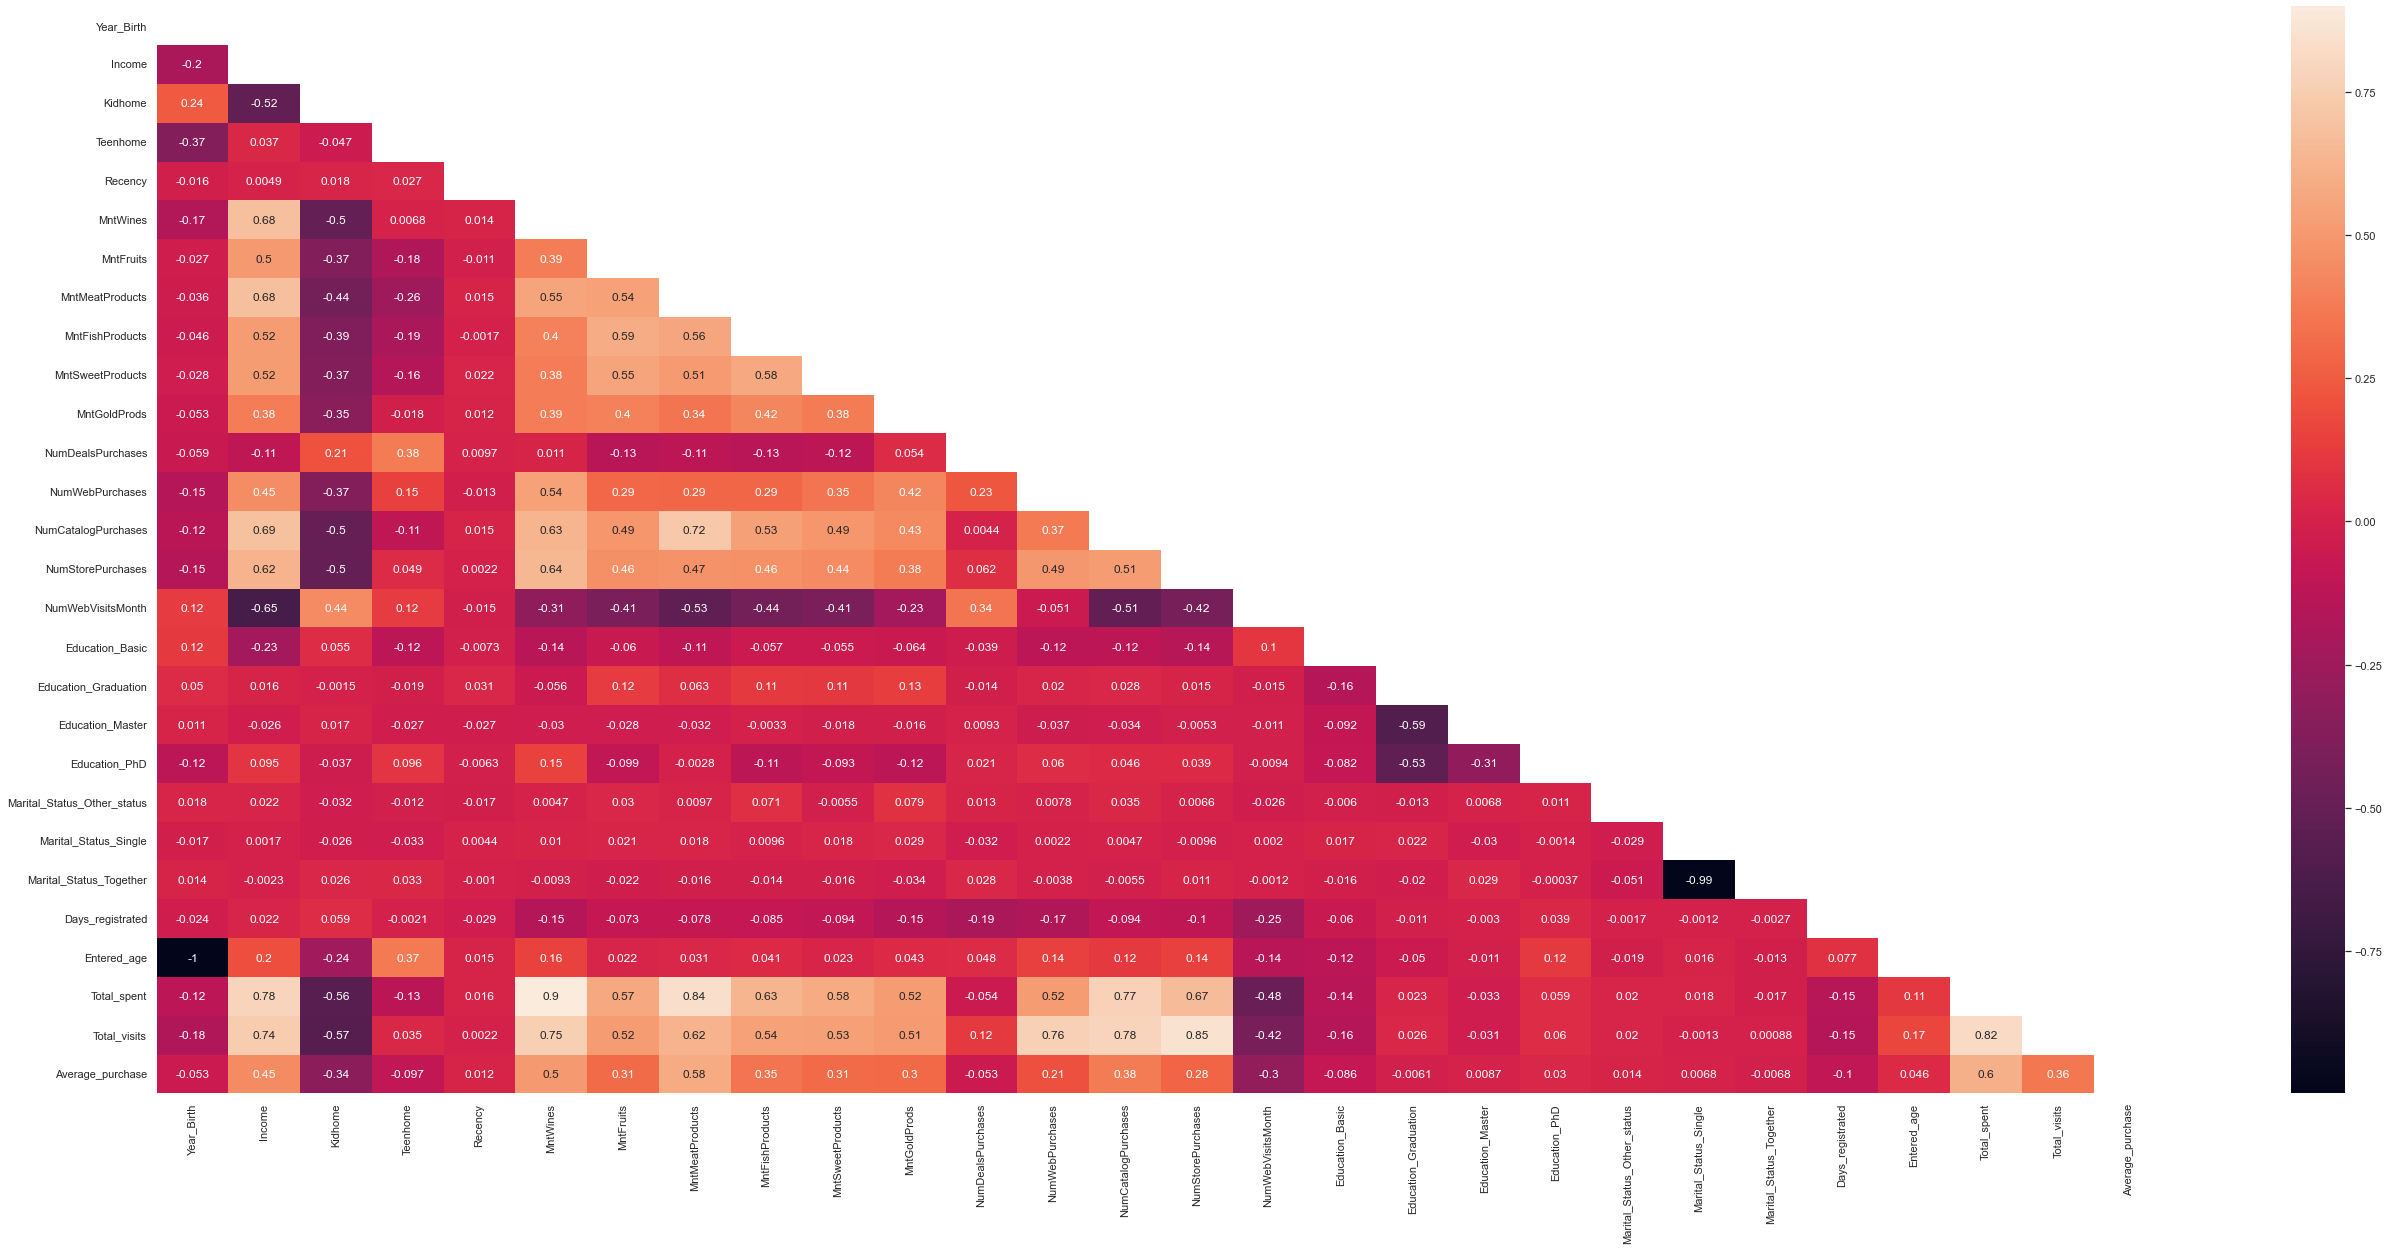

In [59]:
# Creating a correlation matrix to check for correlation between the variables

plt.figure(figsize=(45,20))

correlation_matrix = data_FA.corr()

mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix, annot=True, mask=mask)
plt.show()

Before you perform factor analysis, you need to evaluate the “factorability” of our dataset. Factorability means "can we found the factors in the dataset?".

**Kaiser-Meyer-Olkin (KMO) Test** measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [60]:
# Assessing the full dataset
kmo_all,kmo_model=calculate_kmo(data_FA)
kmo_model

0.501331536528525

In [61]:
# Creating a subset with only customer's purchaces habbits
dfas = data_FA[['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]
dfas.shape

(2033, 11)

In [62]:
# Assessing the subset
kmo_all,kmo_model=calculate_kmo(dfas)
kmo_model

0.8712852817942318

In [63]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(dfas, 11)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([5.06079121, 1.53738434, 0.83730753, 0.6959387 , 0.62198302,
       0.52501209, 0.46323645, 0.40101569, 0.36039089, 0.26681012,
       0.23012995])

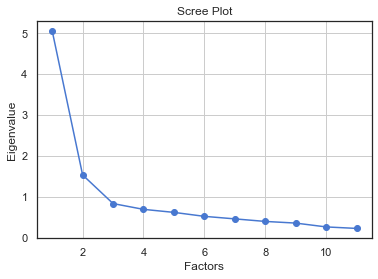

In [64]:
# Create scree plot using matplotlib
plt.scatter(range(1,dfas.shape[1]+1),ev)
plt.plot(range(1,dfas.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [65]:
# With 3 factors and None 
fa1 = FactorAnalyzer()
fa1.set_params(n_factors=3, rotation= None )
fa1.fit(dfas)
faResults1 = pd.DataFrame(fa1.loadings_).T
faResults1 = faResults1.set_axis([dfas.columns], axis=1, inplace=False).T
faResults1

,0,1,2
MntWines,0.725719,0.294497,-0.292155
MntFruits,0.693260,-0.149341,0.251584
MntMeatProducts,0.771328,-0.160997,-0.153911
MntFishProducts,0.724557,-0.171297,0.258484
MntSweetProducts,0.683514,-0.111409,0.249983
MntGoldProds,0.547169,0.171819,0.163643
NumDealsPurchases,-0.080245,0.500071,0.036212
NumWebPurchases,0.529692,0.566523,0.095448
NumCatalogPurchases,0.793410,-0.003684,-0.211212
NumStorePurchases,0.705783,0.192319,-0.086139


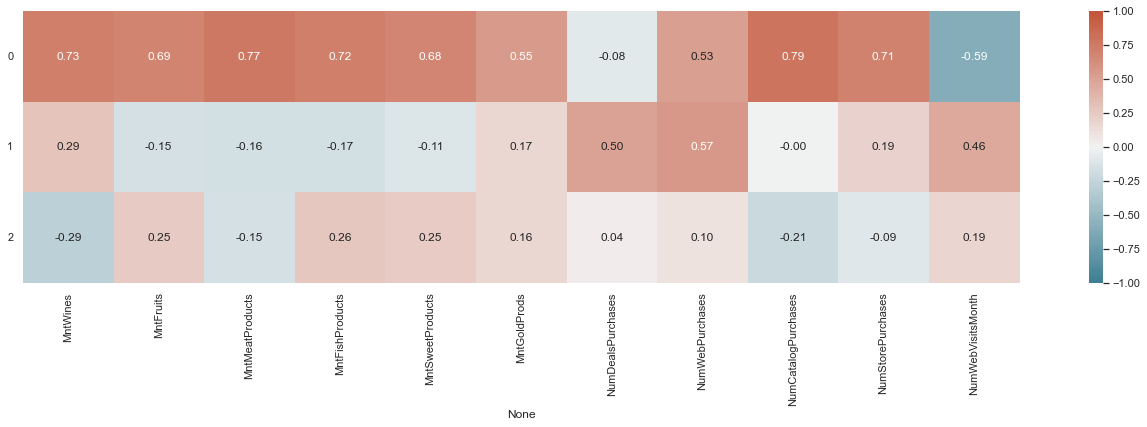

In [66]:
# Ploating the loadings
plt.figure(figsize=(25,5))

# plot the heatmap for correlation matrix
ax = sns.heatmap(faResults1.T, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0.45)

plt.show()

In [67]:
# With 3 factors and Rotation 
fa = FactorAnalyzer()
fa.set_params(n_factors=3, rotation= "varimax")
fa.fit(dfas)
faResults = pd.DataFrame(fa.loadings_).T
faResults = faResults.set_axis([dfas.columns], axis=1, inplace=False).T
faResults.set_axis(['Factor 1','Factor 2', 'Factor 3' ], axis=1, inplace=True)
faResults

,Factor 1,Factor 2,Factor 3
MntWines,0.775451,0.266546,0.162417
MntFruits,0.293317,0.678676,-0.139894
MntMeatProducts,0.617355,0.447741,-0.250911
MntFishProducts,0.306258,0.707886,-0.161996
MntSweetProducts,0.295625,0.666445,-0.102726
MntGoldProds,0.317294,0.478142,0.162481
NumDealsPurchases,0.026468,-0.087055,0.499542
NumWebPurchases,0.435508,0.373003,0.530881
NumCatalogPurchases,0.705281,0.404810,-0.113273
NumStorePurchases,0.601563,0.409891,0.112461


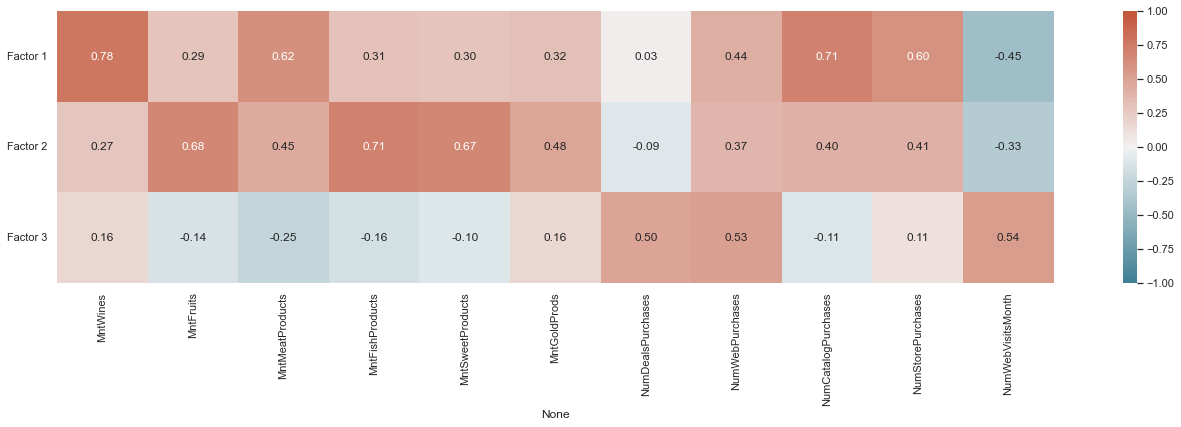

In [68]:
# Ploating the loadings
plt.figure(figsize=(25,5))

ax = sns.heatmap(faResults.T, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0)

plt.show()

In [69]:
# The factor models explained 41% of the total variance of the used dataset (sum of communalities 1,24 out of 3)
pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])  

,0,1,2
Variance,2.599157,2.494809,1.016427
Proportional Var,0.236287,0.226801,0.092402
Cumulative Var,0.236287,0.463088,0.555490


## Performing PCA

In [70]:
pca=dcp.PCA(n_components=10)

In [71]:
# Preparing the data for PCA
df_pca=df_no_dummy.copy()

# Creating new feature: Minorhome
df_pca["Minorhome"]=df_pca.Kidhome+df_pca.Teenhome
df_pca.drop(columns=["Kidhome","Teenhome"], inplace=True)

In [72]:
# Creating new features: Total_amount_spent and Total_number_purchases
df_pca["Total_amount_spent"]=df_pca.MntWines+df_pca.MntFruits+df_pca.MntFishProducts+df_pca.MntSweetProducts+df_pca.MntGoldProds
df_pca["Total_number_purchases"]=df_pca.NumDealsPurchases+df_pca.NumWebPurchases+df_pca.NumCatalogPurchases+df_pca.NumStorePurchases+df_pca.NumWebVisitsMonth

# Dropping some columns
df_pca.drop(columns=["Income","ID","Marital_Status", "Education",
"Dt_Customer","Total_spent"], inplace=True)

df_pca.head()

,Year_Birth,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Days_registrated,Entered_age,Total_visits,Average_purchase,Minorhome,Total_amount_spent,Total_number_purchases
0,1957,58,635,88,546,172,88,88,3,8,10,4,7,92,55,22,69.500000,0,1071,32
1,1954,38,11,1,6,2,1,6,2,1,1,2,5,938,60,4,6.500000,2,21,11
2,1965,26,426,49,127,111,21,42,1,8,2,10,4,591,48,20,36.350000,0,649,25
3,1984,26,11,4,20,10,3,5,2,2,0,4,6,998,30,6,8.166667,1,33,14
4,1981,94,173,43,118,46,27,15,5,5,3,6,5,742,33,14,27.071429,1,304,24


In [73]:
# Fitting the PCA
pca.fit_transform(df_pca)

array([[ 8.27566457e+02, -3.85486402e+02,  2.24541120e+02, ...,
        -1.11402724e+01, -2.01327286e-01, -1.67025017e+01],
       [-5.66167509e+02,  3.41261463e+02, -4.13425730e+01, ...,
         8.43707348e+00,  3.18034523e+00, -2.16913564e+01],
       [ 2.21019261e+02,  4.82939804e+01, -9.49762546e+01, ...,
         1.98590517e+01, -9.58304016e+00, -3.80057256e+00],
       ...,
       [ 7.91837986e+02,  2.44738673e+02, -2.34029000e+02, ...,
        -3.46605737e+01, -3.63693851e+01,  2.40278348e+01],
       [ 2.18230633e+02,  2.09975552e+02, -2.77449009e+01, ...,
         3.47929923e+01,  1.39373777e+01, -1.72090218e+01],
       [-3.88227815e+02, -3.00968236e+02,  2.02179147e+01, ...,
         9.51797264e+00,  5.93599718e-01, -2.36012543e+01]])

In [74]:
np.cumsum(pca.explained_variance_ratio_)

array([0.76422497, 0.89099999, 0.9668155 , 0.9859578 , 0.99002601,
       0.99313627, 0.99544122, 0.99747588, 0.99921995, 0.99985378])

In [75]:
loadings=pd.DataFrame(pca.components_[0:3,:].T).set_index(np.arange(1,21))
loadings.columns=["z1","z2","z3"]
loadings.index=df_pca.columns
loadings

,z1,z2,z3
Year_Birth,-0.003044,-0.002436,0.006673
Recency,0.000767,-0.003424,0.001421
MntWines,0.577785,0.037162,-0.348695
MntFruits,0.038037,0.006845,0.067107
MntMeatProducts,0.278684,0.089380,0.916426
MntFishProducts,0.054601,0.007768,0.098938
MntSweetProducts,0.039260,0.002682,0.064862
MntGoldProds,0.046631,-0.014479,0.020019
NumDealsPurchases,-0.000063,-0.001754,-0.001379
NumWebPurchases,0.002780,-0.000959,-0.001796


We can't see much from this, so let's try sparse pca.

## Performing sparse PCA 

In [76]:
df_pca_1 = df.drop(columns=["ID","Dt_Customer","Total_spent","Days_registrated","Average_purchase"])
df_pca_1["Minorhome"] = df.Kidhome + df.Teenhome
df_pca_1.drop(columns=["Kidhome","Teenhome"], inplace=True)

In [77]:
df_pca_1.dropna(inplace=True)
pca.fit_transform(df_pca_1)
pca_sparse=dcp.SparsePCA(alpha=5, n_components=5)
pca_sparse.fit(df_pca_1)
loadings_sparse=pd.DataFrame(pca_sparse.components_.T).set_index(np.arange(1,25))
loadings_sparse.index=df_pca_1.columns
loadings_sparse

,0,1,2,3,4
Year_Birth,-0.000136,-0.002784,0.008137,0.008633,0.000000
Income,0.999977,0.000000,0.000000,0.000000,0.000000
Recency,0.000000,0.000724,0.001990,-0.004237,0.005045
MntWines,0.005931,0.999944,0.000000,0.000000,0.000000
MntFruits,0.000169,0.000000,0.016274,0.392294,0.063404
MntMeatProducts,0.003246,0.000000,0.999780,0.000000,0.000000
MntFishProducts,0.000000,0.001465,0.000000,0.807797,0.000000
MntSweetProducts,0.000260,-0.000680,0.002520,0.439294,0.027407
MntGoldProds,0.000000,0.000000,0.000000,0.000000,0.997275
NumDealsPurchases,-0.000002,0.000235,0.000000,-0.003308,0.001546


In [78]:
# drop all education and marital status since it's all zeros
df_pca_1.drop(columns=["Education_Basic","Education_Graduation","Education_Master","Education_PhD","Marital_Status_Other_status","Marital_Status_Single","Marital_Status_Together"], inplace=True)
pca.fit_transform(df_pca_1)
pca_sparse=dcp.SparsePCA(alpha=5, n_components=5)
pca_sparse.fit(df_pca_1)
loadings_sparse=pd.DataFrame(pca_sparse.components_.T).set_index(np.arange(1,18))
loadings_sparse.columns=["z1","z2","z3","z4","z5"]
loadings_sparse.index=df_pca_1.columns
loadings_sparse

,z1,z2,z3,z4,z5
Year_Birth,-0.000136,-0.002784,0.008137,0.008633,0.000000
Income,0.999977,0.000000,0.000000,0.000000,0.000000
Recency,0.000000,0.000724,0.001990,-0.004237,0.005045
MntWines,0.005931,0.999944,0.000000,0.000000,0.000000
MntFruits,0.000169,0.000000,0.016274,0.392294,0.063404
MntMeatProducts,0.003246,0.000000,0.999780,0.000000,0.000000
MntFishProducts,0.000000,0.001465,0.000000,0.807797,0.000000
MntSweetProducts,0.000260,-0.000680,0.002520,0.439294,0.027407
MntGoldProds,0.000000,0.000000,0.000000,0.000000,0.997275
NumDealsPurchases,-0.000002,0.000235,0.000000,-0.003308,0.001546


We saw from the results that z1 represented the income, while z2 represented the amount spent on wine , z3 represented the amount spent on meat, z4 represented the amount spent on fruits, fish, and sweet, and z5 represented the amount spent on gold.

# Perform Clustering using K-Means 

In order to do clustering we drop all demographic characteristics because we are interested in customer behaviour first. 

In [79]:
data_for_k_means = df.drop(['Dt_Customer','ID', 'Income', 'Recency', 'Year_Birth', 'Kidhome', 
                      'Teenhome', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Other_status',
                      'Marital_Status_Single', 'Marital_Status_Together', 'Entered_age', 'Average_purchase', 'Total_visits', 'Total_spent', 'Days_registrated'], axis=1)
data_for_k_means.astype(float) 

data1 = df.drop(['Dt_Customer','ID'], axis=1)

data1['spending_on_wine_per_visit'] = data1['MntWines']/data1['Total_visits']

data_for_k_means

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,635,88,546,172,88,88,3,8,10,4,7
1,11,1,6,2,1,6,2,1,1,2,5
2,426,49,127,111,21,42,1,8,2,10,4
3,11,4,20,10,3,5,2,2,0,4,6
4,173,43,118,46,27,15,5,5,3,6,5
...,...,...,...,...,...,...,...,...,...,...,...
2232,5,1,6,3,4,3,1,0,0,3,4
2235,709,43,182,42,118,247,2,9,3,4,5
2237,908,48,217,32,12,24,1,2,3,13,6
2238,428,30,214,80,30,61,2,6,5,10,3


In [80]:
data_for_k_means.columns

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth'],
      dtype='object')

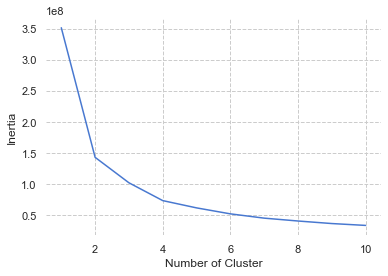

In [81]:
# Choosing the right K
# The k-mean algorithm is carried out for a range of values k from 1 to 10 
inertia_K = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_for_k_means)
    inertia_K.append(kmeanModel.inertia_)
    
# inertia =  sum(distance of each point in the cluster to the centroid of the cluster)^2
ax = plt.subplot(111)
plt.plot(K,inertia_K)
plt.grid(ls='--')
plt.xlabel('Number of Cluster', size=12)
plt.ylabel('Inertia', size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig('K-means_inertia.png')
plt.show()



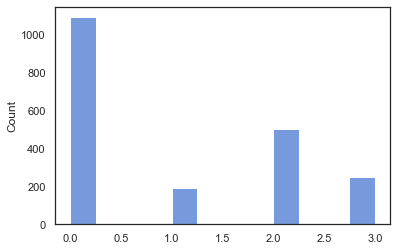

In [82]:
kmeans = KMeans(n_clusters = 4).fit(data_for_k_means)

# Plot the result of an assignation of the original data to single clusters

labels = kmeans.labels_
sns.histplot(labels)
plt.savefig('K-means_clusters.png')
plt.show()

In [83]:
kmeans.labels_[0:20]

array([1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 3, 0],
      dtype=int32)

In [84]:
data1["Labels"] = kmeans.labels_
# Summary of each cluster
clusters_k_means = pd.DataFrame(data1.groupby(data1["Labels"])[data1.columns].mean())

In [85]:
data1[0:20]

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Status_Other_status,Marital_Status_Single,Marital_Status_Together,Days_registrated,Entered_age,Total_spent,Total_visits,Average_purchase,spending_on_wine_per_visit,Labels
0,1957,58138.000000,0,0,58,635,88,546,172,88,...,0,1,0,92,55,1529,22,69.500000,28.863636,1
1,1954,46344.000000,1,1,38,11,1,6,2,1,...,0,1,0,938,60,26,4,6.500000,2.750000,0
2,1965,71613.000000,0,0,26,426,49,127,111,21,...,0,0,1,591,48,727,20,36.350000,21.300000,2
3,1984,26646.000000,1,0,26,11,4,20,10,3,...,0,0,1,998,30,49,6,8.166667,1.833333,0
4,1981,58293.000000,1,0,94,173,43,118,46,27,...,0,0,1,742,33,379,14,27.071429,12.357143,0
5,1967,62513.000000,0,1,16,520,42,98,0,42,...,0,0,1,610,46,674,20,33.700000,26.000000,2
6,1971,55635.000000,0,1,34,235,65,164,50,49,...,0,1,0,310,41,525,17,30.882353,13.823529,2
7,1985,33454.000000,1,0,32,76,10,56,3,1,...,0,0,1,575,28,159,8,19.875000,9.500000,0
8,1974,30351.000000,1,0,19,14,0,24,3,3,...,0,0,1,515,39,46,5,9.200000,2.800000,0
9,1950,5648.000000,1,1,68,28,0,6,1,1,...,0,0,1,795,64,49,1,49.000000,28.000000,0


In [86]:
# Summary of each cluster
clusters_k_means.T

Labels,0,1,2,3
Year_Birth,1970.726856,1969.424084,1966.235060,1965.843373
Income,37402.875642,78490.438235,63228.686781,73037.992583
Kidhome,0.724106,0.026178,0.175299,0.088353
Teenhome,0.497709,0.083770,0.719124,0.457831
Recency,49.088909,51.010471,48.081673,49.469880
MntWines,57.569203,515.387435,421.183267,978.301205
MntFruits,8.318973,70.120419,39.653386,44.775100
MntMeatProducts,33.721357,691.549738,179.864542,327.586345
MntFishProducts,11.449129,104.146597,55.364542,64.325301
MntSweetProducts,8.441797,70.607330,42.639442,45.473896


<__array_function__ internals>:180: UserWarning:


/Users/xiaojianing/opt/anaconda3/envs/adl/lib/python3.8/site-packages/matplotlib/colors.py:1211: UserWarning:


/Users/xiaojianing/opt/anaconda3/envs/adl/lib/python3.8/site-packages/matplotlib/ticker.py:547: UserWarning:




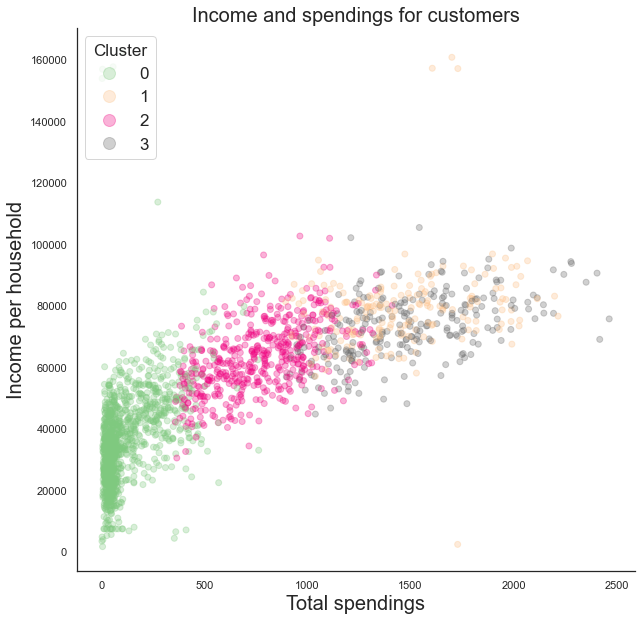

In [87]:
# Plotting the relationship between salary and spending
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

values = data1['Labels']
classes = [0,1,2,3]
#colors = ListedColormap(['red', 'blue', 'purple', 'yellow'])

scatter = ax.scatter(df_no_dummy['Total_spent'],df_no_dummy['Income'], alpha = 0.3, c = values, cmap= 'Accent' )


#ax.scatter(data1['Total_spent'][data1['Labels'] == 0],data1['Income'][data1['Labels'] == 0],color='wheat',label="0", alpha = 0.5)
#ax.scatter(data1['Total_spent'][data1['Labels'] == 1],data1['Income'][data1['Labels'] == 1],color='palegreen',label="1", alpha = 0.5)
#ax.scatter(data1['Total_spent'][data1['Labels'] == 2],data1['Income'][data1['Labels'] == 2],color='lightblue',label="2", alpha = 0.5)
#ax.scatter(data1['Total_spent'][data1['Labels'] == 3],data1['Income'][data1['Labels'] == 3],color='lightyellow',label="3", alpha = 0.5)



#ax.set_xscale('log')
#ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Total spendings', size = 20)
ax.set_ylabel('Income per household', size = 20)
ax.set_title('Income and spendings for customers', size = 20)
#ax.legend(data1['Labels'][0:10])
#plt.legend(title = 'Cluster', loc = 'upper left')

plt.legend(handles=scatter.legend_elements()[0], labels=classes, title = 'Cluster', loc = 'upper left', fontsize = 17, markerscale = 2, title_fontsize  = 17  )


plt.savefig('K-means_income-spendings.png')
plt.show()

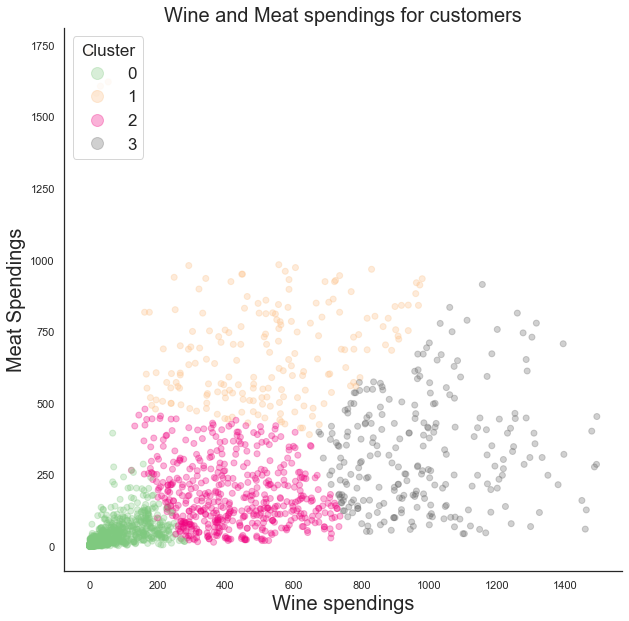

In [88]:
# Plotting the relationship between salary and spending

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


scatter = ax.scatter(df_no_dummy['MntWines'],df_no_dummy['MntMeatProducts'], alpha = 0.3, c = data1['Labels'], cmap= 'Accent' )
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Wine spendings', size = 20)
ax.set_ylabel('Meat Spendings', size = 20)
ax.set_title('Wine and Meat spendings for customers', size = 20)
#ax.legend(data1['Labels'][0:10])


#scatter = plt.scatter(x, y, c=values, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0],labels=classes, title = 'Cluster', 
           loc = 'upper left', fontsize = 17, markerscale = 2, title_fontsize  = 17  )

plt.savefig('K-means_wine-meat.png')
plt.show()

In [89]:
df_cut = df.drop(['ID', 'Dt_Customer'], axis = 1)
df_scaled_new= pd.DataFrame(preprocessing.scale(df_cut))
df_scaled_new.columns = df_cut.columns
df_scaled_new["Labels"]=kmeans.labels_ #we do not need scaled labels
df_scaled_new

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_PhD,Marital_Status_Other_status,Marital_Status_Single,Marital_Status_Together,Days_registrated,Entered_age,Total_spent,Total_visits,Average_purchase,Labels
0,-1.021804,0.284658,-0.827640,-0.929961,0.308546,0.990122,1.550575,1.662478,2.457815,1.455683,...,-0.524793,-0.038443,1.343182,-1.334587,-1.984882,0.929910,1.645261,1.317035,0.707128,1
1,-1.279463,-0.262720,1.031578,0.898482,-0.382284,-0.871600,-0.636789,-0.709999,-0.648212,-0.629417,...,-0.524793,-0.038443,1.343182,-1.334587,1.660165,1.357898,-0.958338,-1.189105,-0.646157,0
2,-0.334715,0.910054,-0.827640,-0.929961,-0.796782,0.366565,0.570032,-0.178389,1.343300,-0.150083,...,-0.524793,-0.038443,-0.744501,0.749296,0.165092,0.330727,0.255982,1.038575,-0.004958,2
3,1.297122,-1.176936,1.031578,-0.929961,-0.796782,-0.871600,-0.561363,-0.648490,-0.502046,-0.581484,...,-0.524793,-0.038443,-0.744501,0.749296,1.918679,-1.210028,-0.918496,-0.910645,-0.610356,0
4,1.039463,0.291852,1.031578,-0.929961,1.552040,-0.388268,0.419180,-0.217930,0.155701,-0.006283,...,1.905513,-0.038443,-0.744501,0.749296,0.815686,-0.953236,-0.346847,0.203195,-0.204268,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,1.468894,-1.169046,-0.827640,-0.929961,0.032214,-0.889501,-0.636789,-0.709999,-0.629941,-0.557517,...,-0.524793,-0.038443,1.343182,-1.334587,-1.424769,-1.552418,-0.966999,-1.328335,-0.635417,0
2029,-0.162943,0.427838,-0.827640,0.898482,-0.105952,1.210903,0.419180,0.063253,0.082618,2.174684,...,-0.524793,-0.038443,-0.744501,0.749296,-0.132199,0.159532,1.245107,0.481655,0.956841,2
2030,1.039463,0.230960,-0.827640,-0.929961,1.448416,1.804625,0.544890,0.217024,-0.100089,-0.365784,...,-0.524793,-0.038443,1.343182,-1.334587,0.841537,-0.953236,1.063219,0.760115,0.637912,3
2031,-1.107691,0.800152,-0.827640,0.898482,-1.418530,0.372532,0.092332,0.203844,0.776907,0.065617,...,-0.524793,-0.038443,-0.744501,0.749296,0.837229,1.186703,0.404957,1.177805,0.045829,2


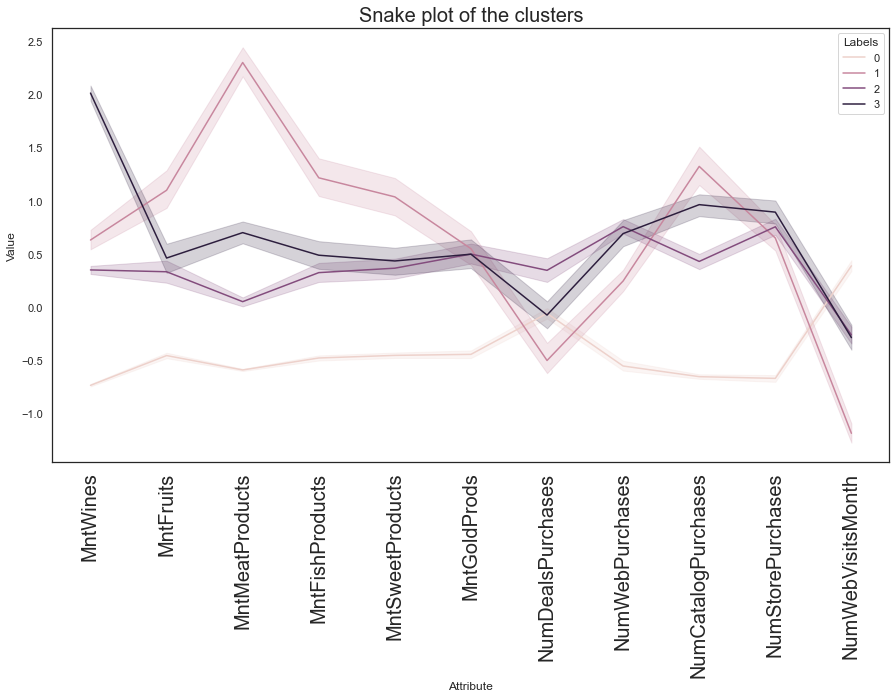

In [90]:

fig = plt.figure(figsize = (15, 8))

ax1 = fig.add_subplot(111)

x_labels = ('MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
            'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth')


C1=df_scaled_new.copy()
C1["Labels"]=kmeans.labels_
C1_melt = pd.melt(C1.reset_index(),
                  id_vars=['Labels'],
                  value_vars= ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
            'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth'],
                  var_name='Attribute',value_name='Value')
plt.title('Snake plot of the clusters', size =20)
g = sns.lineplot(x="Attribute", y="Value", hue='Labels', data=C1_melt, ax = ax1 )
#g.set_xticklabels(x_labels)
g.tick_params(axis = 'x', labelsize=20, rotation=90)
plt.savefig('K-means_snake_behaviour.png')
plt.show()

<ipython-input-91-33d0834cb060>:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



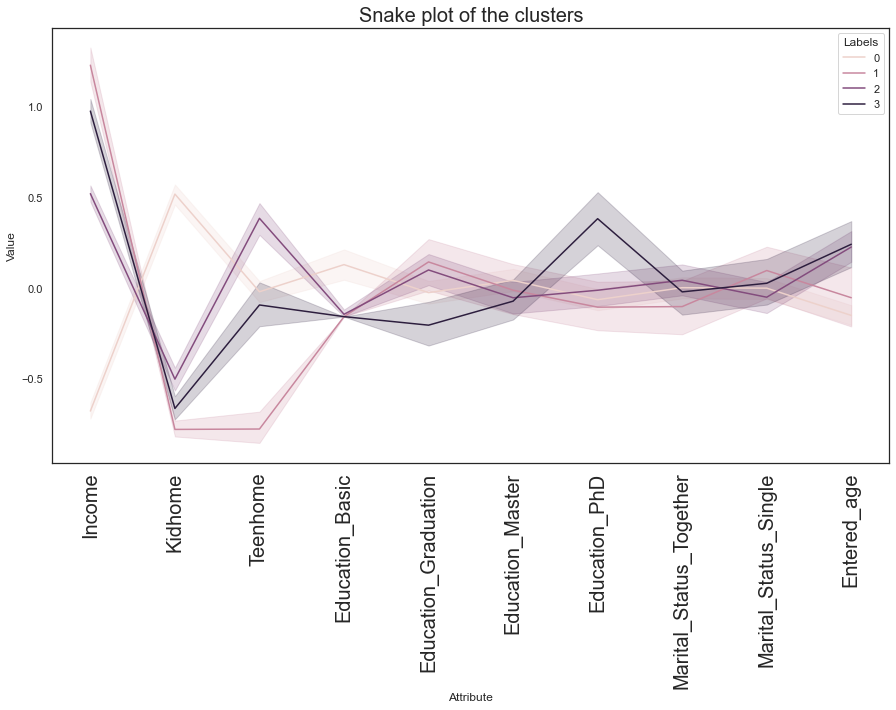

In [91]:
fig = plt.figure(figsize = (15, 8))

ax1 = fig.add_subplot(111)

x_labels = ('Income','Kidhome', 
                      'Teenhome', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD',
                      'Marital_Status_Together', 'Marital_Status_Single', 'Entered_age' )


C1=df_scaled_new.copy()
C1["Labels"]=kmeans.labels_
C1_melt = pd.melt(C1.reset_index(),
                  id_vars=['Labels'],
                  value_vars= ['Income','Kidhome', 
                      'Teenhome', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD',
                       'Marital_Status_Together','Marital_Status_Single', 'Entered_age'],
                  var_name='Attribute',value_name='Value')
plt.title('Snake plot of the clusters', size = 20)
g = sns.lineplot(x="Attribute", y="Value", hue='Labels', data=C1_melt, ax = ax1)
g.set_xticklabels(x_labels)
g.tick_params(axis = 'x', labelsize=20, rotation=90)
plt.savefig('K-means_snake_demog.png')
plt.show()

## Let's see some plots for different clusters:

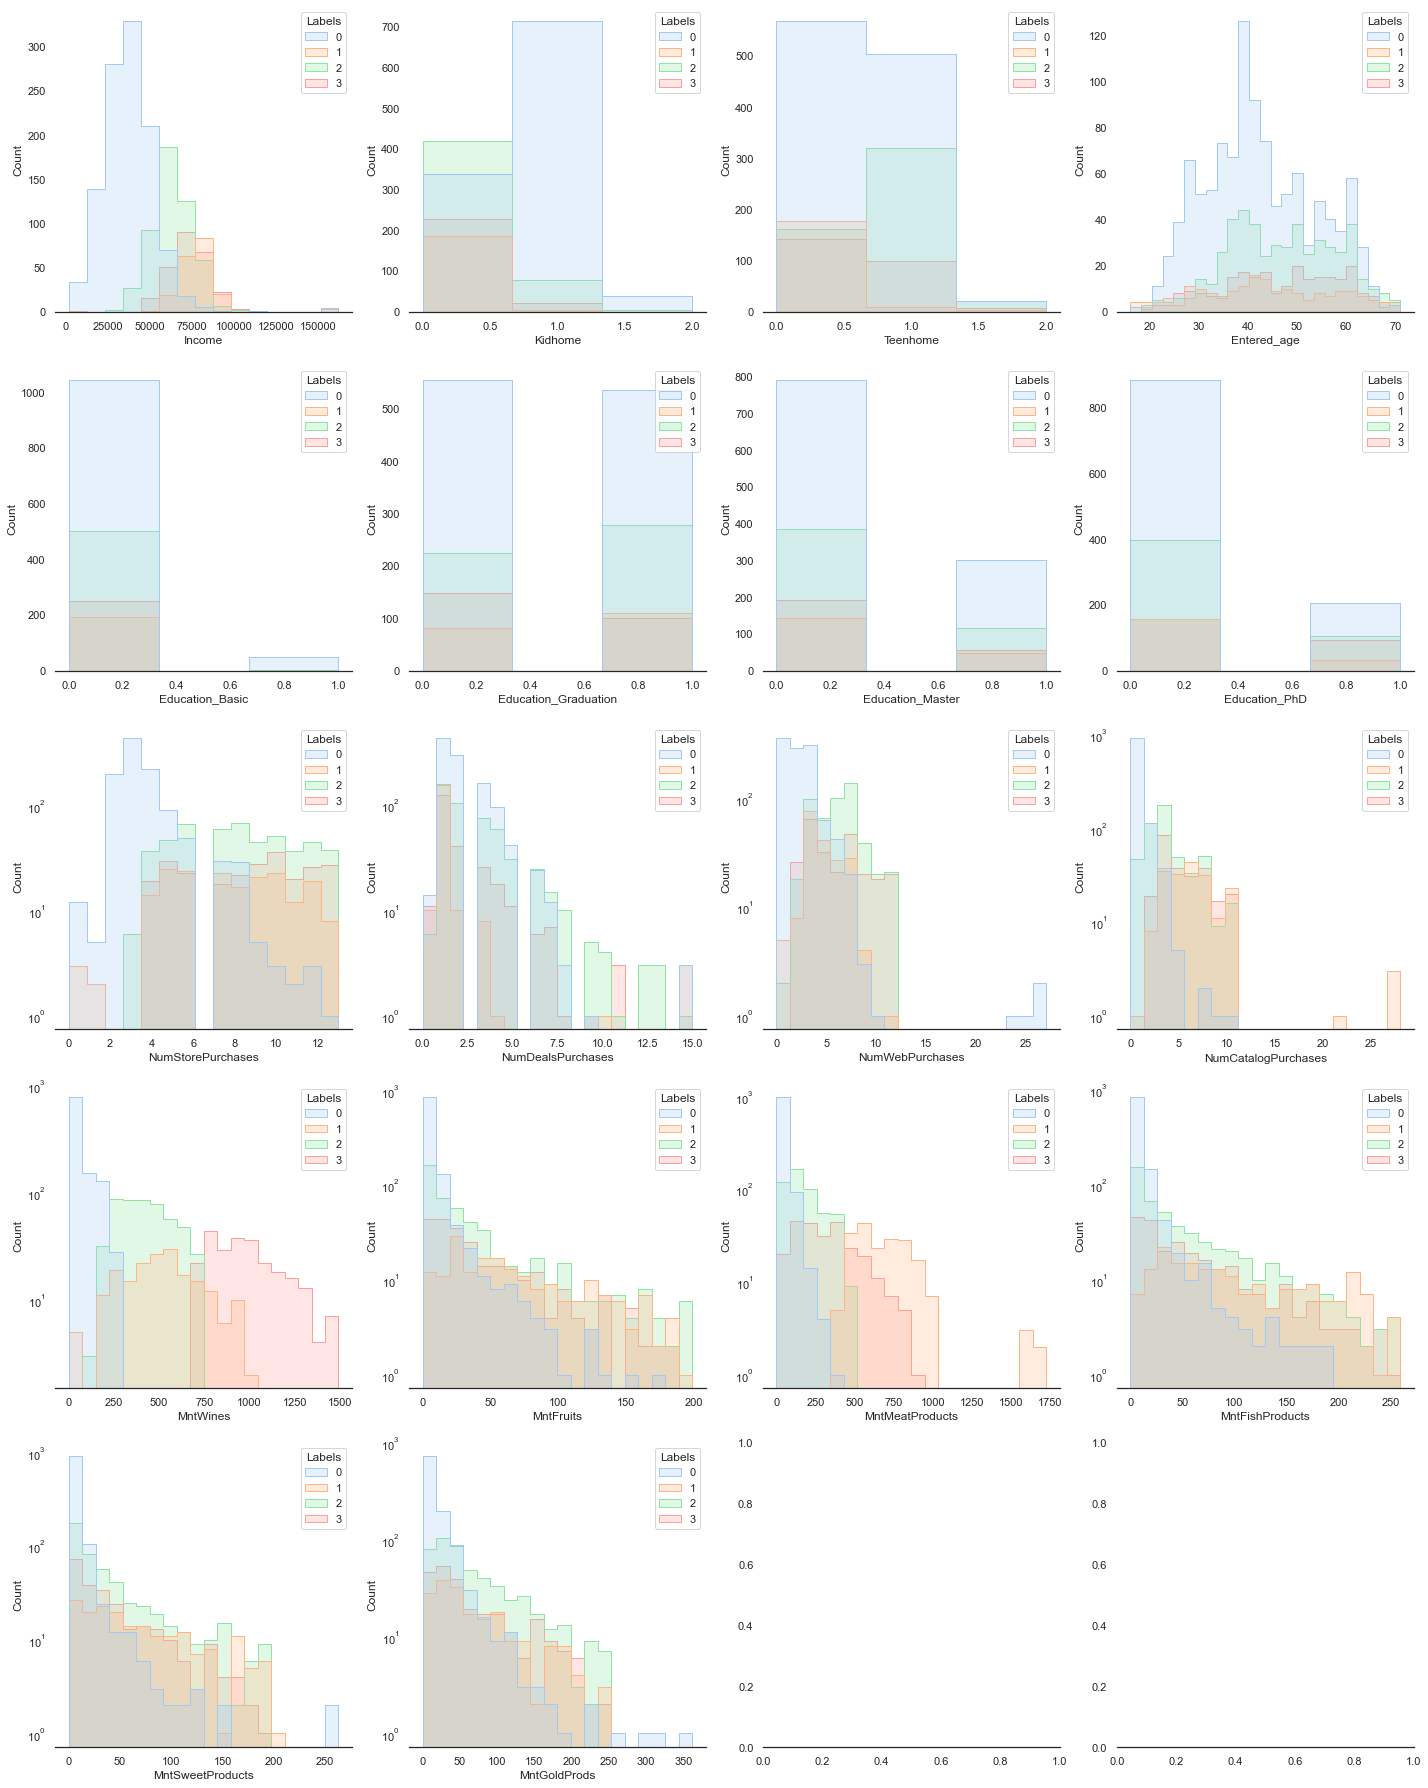

In [92]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(5, 4, figsize=(20, 25), sharex=False)
sns.despine(left=True)

#create subplots

sns.histplot(data1, x="Income", hue="Labels", element="step", ax=axes[0, 0], bins = 15, palette = 'pastel' )

sns.histplot(data1, x="Kidhome", hue="Labels", element="step", ax=axes[0, 1], bins = 3, palette = 'pastel' )

sns.histplot(data1, x="Teenhome", hue="Labels", element="step", ax=axes[0, 2], bins = 3, palette = 'pastel' )

sns.histplot(data1, x="Entered_age", hue="Labels", element="step", ax=axes[0, 3], bins = 25, palette = 'pastel' )


sns.histplot(data1, x="Education_Basic", hue="Labels", element="step", ax=axes[1, 0], bins = 3, palette = 'pastel' )

sns.histplot(data1, x="Education_Graduation", hue="Labels", element="step", ax=axes[1, 1], bins = 3, palette = 'pastel' )

sns.histplot(data1, x="Education_Master", hue="Labels", element="step", ax=axes[1, 2], bins = 3, palette = 'pastel' )

sns.histplot(data1, x="Education_PhD", hue="Labels", element="step", ax=axes[1, 3], bins = 3, palette = 'pastel' )


sns.histplot(data1, x="NumStorePurchases", hue="Labels", element="step", ax=axes[2, 0], bins = 15, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="NumDealsPurchases", hue="Labels", element="step", ax=axes[2, 1], bins = 20, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="NumWebPurchases", hue="Labels", element="step", ax=axes[2, 2], bins = 20, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="NumCatalogPurchases", hue="Labels", element="step", ax=axes[2, 3], bins = 20, palette = 'pastel', log_scale=(False, True) )


sns.histplot(data1, x="MntWines", hue="Labels", element="step", ax=axes[3, 0], bins = 20, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="MntFruits", hue="Labels", element="step", ax=axes[3, 1], bins = 20, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="MntMeatProducts", hue="Labels", element="step", ax=axes[3, 2], bins = 20, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="MntFishProducts", hue="Labels", element="step", ax=axes[3, 3], bins = 20, palette = 'pastel', log_scale=(False, True) )


sns.histplot(data1, x="MntSweetProducts", hue="Labels", element="step", ax=axes[4, 0], bins = 20, palette = 'pastel', log_scale=(False, True) )

sns.histplot(data1, x="MntGoldProds", hue="Labels", element="step", ax=axes[4, 1], bins = 20, palette = 'pastel',  log_scale=(False, True))

#sns.histplot(data1, x="NumDealsPurchases", hue="Labels", element="step", ax=axes[4, 2], bins = 20, palette = 'pastel' )

#sns.histplot(data1, x="MntSweetProducts", hue="Labels", element="step", ax=axes[4, 3], bins = 20, palette = 'pastel' )


plt.savefig('K-means_all_distributions.png')



plt.tight_layout()